# Exploring Meshing Functions
In this notebook I go over the basic functionality of the functions inside renderneuron.py and parallelframe.py.
- First, I print the versions used in this project and then I load the two modules that I created
- Second, I load a .swc from the cells folder
- Then, I save refine geometries (without splines)
- I show an example using spline refinement

In [2]:
import os
import sys
print("Python version: ",sys.version)
print("Version info:   ",sys.version_info)

# add path to get to the modules renderneuron and parallelframe
sys.path.insert(0,'../src/')

# these are the modules I made
import renderneuron as rn
import parallelframe as pf
import somasphere as sph

Python version:  3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0]
Version info:    sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


# Get list of .swc files
Next I make a list of file names, these file names are the names of the .swc files located in the cell folder which contains the sample 1D geometry found in NeuroMorpho.org: [NeuroMorpho.org](https://neuromorpho.org/)

In [3]:
CELL_DIR='../cells/'
OUTPUT_DIR='output/'
if not os.path.exists(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)
# list to store files
res = []
# Iterate directory
for file in os.listdir(CELL_DIR):
    # check only text files
    if file.endswith('.swc'):
        res.append(file)
        print("Cell Name: ",file.replace('.swc',''))

Cell Name:  0-2a.CNG
Cell Name:  108-2_7_2_CA1_R1_N2_CG.CNG
Cell Name:  202-2-20nj.CNG
Cell Name:  228-13MG.CNG
Cell Name:  228-16MG.CNG
Cell Name:  228-21MG.CNG
Cell Name:  229-7MG.CNG
Cell Name:  230-6-NBSS.CNG
Cell Name:  272-1-6-CD.CNG
Cell Name:  73014V1-2Slice3Cell2.CNG
Cell Name:  Culture-100-1.CNG
Cell Name:  Layer-5-Sucrose-1.CNG
Cell Name:  R56_PFC_S2_C5.CNG
Cell Name:  gw-3-image-1_26.CNG
Cell Name:  241-3-56-AW.CNG
Cell Name:  AIBS-glutamatergic23human-Lein_Final


# Getting the Neuron graph and REFINING
+ In this part we will read a .swc file and turn it into a neuron graph. 
+ The neuron graph is storted as Digraph through the networkx module in python. 
+ Each node contains the id, pid (parent id), coordinates (pos), radius (r), and type (t).
+ I use a function called refine_and_save which will save each .swc file

In [4]:
c=res[6]  # I chose index 0 corresponding to the first file in cells
print('Filename: ',c)

# read the lines from the .swc file
lines=rn.read_swc(CELL_DIR+c)

#Now let us add nodes with the x,y,z and r attributes  
G=rn.get_graph(lines)

# name the output
FOLDER=OUTPUT_DIR+c.replace('.swc','')+'_output'

# generate and save the refinements, in this example we will make 5 refinements.
nrefine=5
GG=rn.refine_and_save(G,FOLDER,nrefine)
print('There were ',len(GG), ' refinements made and saved.')

# here I use a function which will return the geometry with the trunks separated
trunks,T=rn.get_trunks(G)
# save the trunks to output
rn.save_to_swc(T,FOLDER+'/trunks.swc')

Filename:  229-7MG.CNG.swc
refining round... 1 2 3 4 5 Done!
There were  6  refinements made and saved.


Let us look at the Hines sparsity matrix

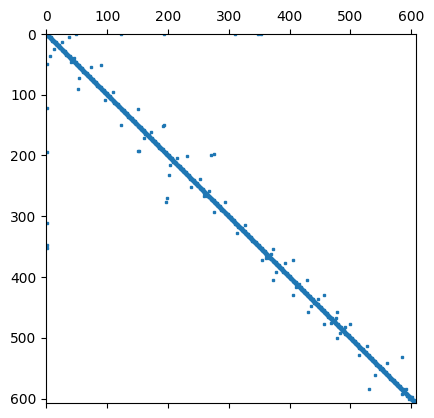

In [5]:
rn.plot_hines_sparsity(G)

Let us look at a rendering of the neuron, I show two plotting functions I made

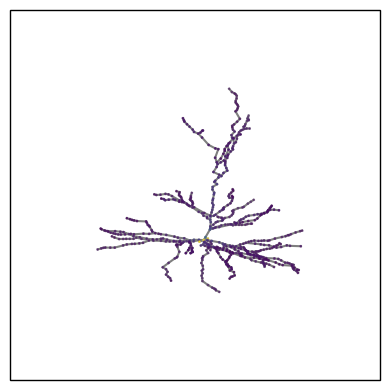

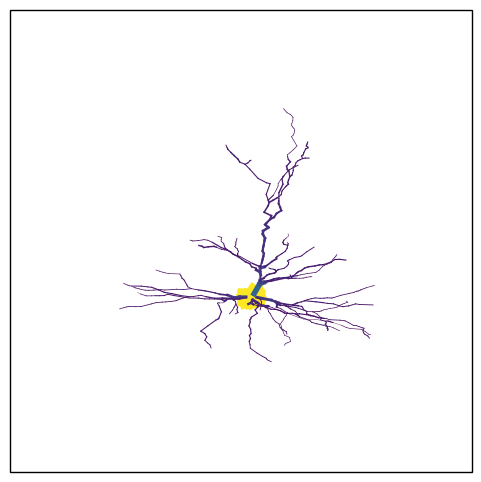

In [6]:
# The first plot is a point plot
rn.plot_neuron(G)

# The second plot is a line plot with edge width corresponding to radius
rn.plot_neuron_r(G)

# Let us make spline refinements now
- In this example I use the same geometry used above except I use splines to regularize the points on the trunks
- I make use of lists for the power (pw), and delta x (dx) is (2^7, 2^6,...,2^-7) this can be modified
- Then I make an output folder
- Then I read in the original .swc cell I want to use
- Then I use a loop to generate the refined spline geometries which are saved to .swc

In [7]:
# make the delta x using powers of 2
pw=list(range(4,-2,-1))
dx=[pow(2,p) for p in pw]

# make output directory
OUTPUT_DIR=c.replace('.swc','')+'_outputSPLINES/'
if not os.path.exists(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)

# read in original .swc cell geometry, I am using c from the previous example
lines=rn.read_swc(CELL_DIR+c)

# get the graph
G=rn.get_graph(lines)

# make another subfolder for all refinements
FOLDER=OUTPUT_DIR+c.replace('.swc','')+'_output'
if not os.path.exists(FOLDER):
    os.mkdir(FOLDER)
    
# make the refinements
print('refining round...',end=' ')
for i in range(len(dx)):
    GS=rn.spline_neuron(G,dx[i])
    print(str(dx[i]),' ',end='')
    rn.save_to_swc(GS,FOLDER+'/refinement'+str(i)+'.swc')
    pf.write_1d_ugx(GS,FOLDER+'/'+c.replace('.swc','')+'_segLength=8_1d_ref_'+str(i)+'.ugx')
print(' Done!')

refining round... 16  8  4  2  1  0.5   Done!


# Make Surface meshes
In this example we will use our spline geometries to make surface meshes

- You need to specify npts because this is the number of points on the each circular contour we are making


In [8]:
# get a list of .swc files from the folder defined in the previous example
allfiles=os.listdir(FOLDER)
files=[]
for f in allfiles:
    if f.endswith('.swc'):
        files.append(f)
print('SWC files that were generated: \n',files)

# set the number of contour points
npts=12

# iterate through the files
print('\nwriting ugx...',end=' ')
for i in range(len(files)):
    # read the lines in the .swc file
    lines=rn.read_swc(FOLDER+'/'+files[i])
    
    # get a graph based on the lines from the .swc file
    X=rn.get_graph(lines)
    
    # get the contours
    cont=pf.get_pft_frames(X,npts)
    
    # set an output file name
    outfilename=FOLDER+'/'+c.replace('.swc','')+'_segLength=8_3d_tris_x1_ref_'+str(i)+'.ugx'
    print(i,' ',end='')
    
    # write the .ugx to file
    pf.write_ugx(cont,X,npts,outfilename)
    outfilename=FOLDER+'/mesh_subsets'+str(i)+'.ugx'
    pf.write_ugx_subsets(cont,X,npts,outfilename)
print('Done!')

SWC files that were generated: 
 ['refinement0.swc', 'refinement1.swc', 'refinement2.swc', 'refinement3.swc', 'refinement4.swc', 'refinement5.swc']

writing ugx... 0  1  2  3  4  5  Done!


In [ ]:
# This will generate a plot of the transported curves which frame the curve
cnt=pf.plot_pft_frames(G)

In [ ]:
# Let us look at the parallel frame vector
pf.plot_pft_vectors(G)

# Replace Soma with Soma Sphere
In this section we remove the soma segment, and then place a soma sphere

In [9]:
# get a list of .swc files from the folder defined in the previous example
allfiles=os.listdir(FOLDER)
files=[]
for f in allfiles:
    if f.endswith('.swc'):
        files.append(f)
print('SWC files that were generated: \n',files)

# make another subfolder for all refinements
NEW_FOLDER='soma_sphere_'+c.replace('.swc','')+'_output'
if not os.path.exists(NEW_FOLDER):
    os.mkdir(NEW_FOLDER)

# set the number of contour points
npts=12

# iterate through the files
print('\nwriting ugx...\n',end=' ')
for i in range(len(files)):
    # read the lines in the .swc file
    lines=rn.read_swc(FOLDER+'/'+files[i])
    
    # get a graph based on the lines from the .swc file
    X=rn.get_graph(lines)
    G2=rn.remove_soma_line(X)
    # get the contours
    pf.write_1d_ugx(G2,NEW_FOLDER+'/'+c.replace('.swc','')+'_soma_line_1d_ref_'+str(i)+'.ugx')
    cont=pf.get_pft_frames(G2,npts)
    
    # set an output file name
    outfilename=NEW_FOLDER+'/'+c.replace('.swc','')+'_soma_sphere_3d_tris_x1_ref_'+str(i)+'.ugx'
    print(i,' ',end='')
    
    # write the .ugx to file
    scale_soma=1.10;
    nsphere_contours=10;
    nsphere_contour_pts=16;
    sph.write_ugx(cont,G2,npts,outfilename,scale_soma,nsphere_contours,nsphere_contour_pts)
    
print('Done!')

SWC files that were generated: 
 ['refinement0.swc', 'refinement1.swc', 'refinement2.swc', 'refinement3.swc', 'refinement4.swc', 'refinement5.swc']

writing ugx...
 0  6420
1  11388
2  21600
3  42552
4  84672
5  168888
Done!


In [10]:
rn.write_vrn(NEW_FOLDER)

Making VRN ...
  adding: 229-7MG.CNG_soma_line_1d_ref_0.ugx (deflated 54%)
  adding: 229-7MG.CNG_soma_sphere_3d_tris_x1_ref_0.ugx (deflated 93%)
  adding: 229-7MG.CNG_soma_line_1d_ref_1.ugx (deflated 54%)
  adding: 229-7MG.CNG_soma_sphere_3d_tris_x1_ref_1.ugx (deflated 93%)
  adding: 229-7MG.CNG_soma_line_1d_ref_2.ugx (deflated 56%)
  adding: 229-7MG.CNG_soma_sphere_3d_tris_x1_ref_2.ugx (deflated 94%)
  adding: 229-7MG.CNG_soma_line_1d_ref_3.ugx (deflated 57%)
  adding: 229-7MG.CNG_soma_sphere_3d_tris_x1_ref_3.ugx (deflated 94%)
  adding: 229-7MG.CNG_soma_line_1d_ref_4.ugx (deflated 56%)
  adding: 229-7MG.CNG_soma_sphere_3d_tris_x1_ref_4.ugx (deflated 94%)
  adding: 229-7MG.CNG_soma_line_1d_ref_5.ugx (deflated 57%)
  adding: 229-7MG.CNG_soma_sphere_3d_tris_x1_ref_5.ugx (deflated 94%)
  adding: MetaInfo.json (deflated 84%)
